In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull, Delaunay
from matplotlib.colors import Normalize
from matplotlib.path import Path
plt.rcParams['figure.dpi'] = 120
plt.rcParams['lines.markerfacecolor'] = 'lime'
plt.rcParams['lines.markeredgecolor'] = 'lime'


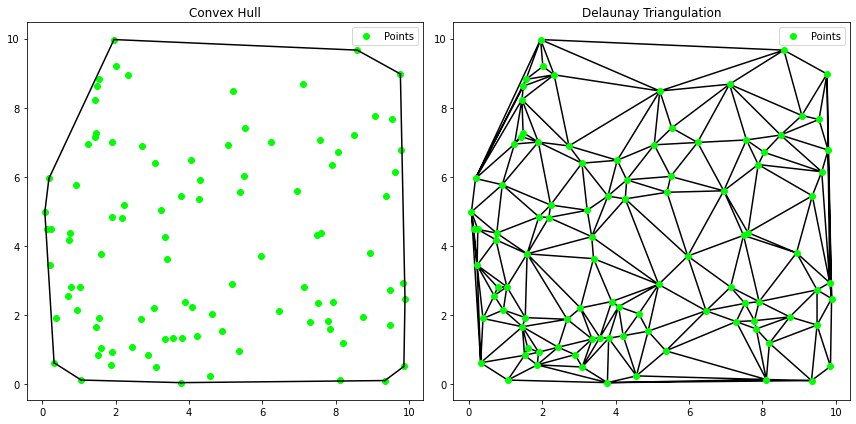

In [4]:
# Prob 3(a)
fp = r'C:\Users\Eric\Desktop\PHYS 129AL\PS2\Code\mesh .dat'
points = np.loadtxt(fp, skiprows=1)


hull = ConvexHull(points)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].plot(points[:, 0], points[:, 1], 'o', label='Points',color='lime')
for simplex in ConvexHull(points).simplices:
    axes[0].plot(points[simplex, 0], points[simplex, 1], 'k-')
axes[0].set_title("Convex Hull")
axes[0].legend()

tri = Delaunay(points)
axes[1].triplot(points[:, 0], points[:, 1], tri.simplices, 'k-')
axes[1].plot(points[:, 0], points[:, 1], 'o', label='Points')
axes[1].set_title("Delaunay Triangulation")
axes[1].legend()

plt.tight_layout()
plt.show()


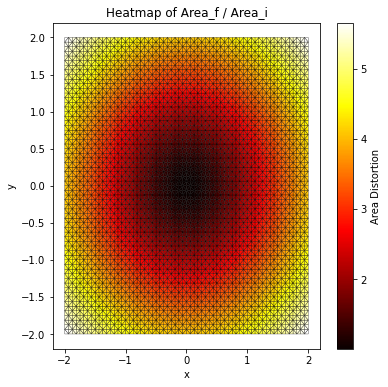

In [5]:
# Prob 3(b)

def lifting_map(x,y):
    return x**2+y**2
def triangle_area(p1, p2, p3):
    return 0.5 * np.linalg.norm(np.cross(p2 - p1, p3 - p1))

# Mesh this surface
mesh = 65
x_vals = np.linspace(-2, 2, mesh)  
y_vals = np.linspace(-2, 2, mesh)  
X, Y = np.meshgrid(x_vals, y_vals)
points = np.column_stack((X.ravel(), Y.ravel()))
Z = lifting_map(points[:, 0], points[:, 1])


# Try to apply the Delaunay traiangle to this lifted mesh
tri = Delaunay(points)

# Map the 2D points to 3D
area_change = []
for simplex in tri.simplices:
    p1, p2, p3 = points[simplex]  # Original (x, y) points
    p1_lifted = np.array([p1[0], p1[1], lifting_map(p1[0], p1[1])])
    p2_lifted = np.array([p2[0], p2[1], lifting_map(p2[0], p2[1])])
    p3_lifted = np.array([p3[0], p3[1], lifting_map(p3[0], p3[1])])
    area_original = triangle_area(np.array([p1[0], p1[1], 0]), np.array([p2[0], p2[1], 0]), np.array([p3[0], p3[1], 0]))
    area_lifted = triangle_area(p1_lifted, p2_lifted, p3_lifted)
    area_change.append((area_lifted) / area_original )

# Plot
plt.figure(figsize=(6, 6))
plt.tripcolor(points[:, 0], points[:, 1], tri.simplices, facecolors=area_change, cmap='hot', edgecolors='k',linewidth=.3)
plt.colorbar(label="Area Distortion")
plt.title("Heatmap of Area_f / Area_i")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


In [6]:
# Prob 3(c)
def induced_metric_analytic(x, y):
    g_11 = 1 + (2 * x) ** 2
    g_12 = (2 * x) * (2 * y)
    g_22 = 1 + (2 * y) ** 2
    return np.array([[g_11, g_12], [g_12, g_22]])


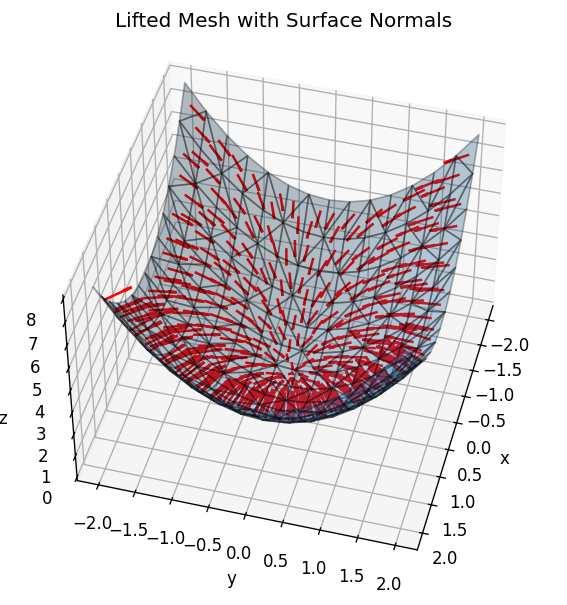

In [7]:
# Prob 3(d)
mesh=15
x_vals = np.linspace(-2, 2, mesh)
y_vals = np.linspace(-2, 2, mesh)
X, Y = np.meshgrid(x_vals, y_vals)
points = np.column_stack((X.ravel(), Y.ravel()))
Z = points[:, 0]**2 + points[:, 1]**2
tri = Delaunay(points[:, :2])
def compute_normal(tri_coord):
    v1, v2, v3 = tri_coord
    edge1 = v2 - v1
    edge2 = v3 - v1
    normal = np.cross(edge1, edge2)
    return normal / np.linalg.norm(normal)  
normals = np.array([compute_normal(np.array([
    [points[i][0], points[i][1], Z[i]] for i in simplex
])) for simplex in tri.simplices])

centers = np.array([
    np.mean([[points[i][0], points[i][1], Z[i]] for i in simplex], axis=0)
    for simplex in tri.simplices
])
fig = plt.figure(figsize=(8, 6),dpi=120)
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(points[:, 0], points[:, 1], Z, triangles=tri.simplices, alpha=0.3, edgecolor='k')
ax.quiver(
    centers[:, 0], centers[:, 1], centers[:, 2],  
    normals[:, 0], normals[:, 1], normals[:, 2], 
    length=0.4, color='red'
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.view_init(elev=45, azim=15)
ax.set_title("Lifted Mesh with Surface Normals")

plt.show()

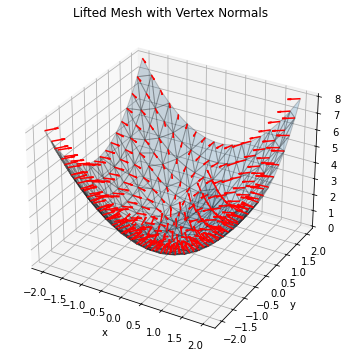

In [8]:
# Prob 3(e)
def compute_normal_and_area(tri_coord):
    v1, v2, v3 = tri_coord
    edge1 = v2 - v1
    edge2 = v3 - v1
    normal = np.cross(edge1, edge2)
    area = 0.5 * np.linalg.norm(normal)  # Triangle area
    return normal / np.linalg.norm(normal), area  # Return normalized normal and area



mesh=18
x_vals = np.linspace(-2, 2, mesh)
y_vals = np.linspace(-2, 2, mesh)
X, Y = np.meshgrid(x_vals, y_vals)
points = np.column_stack((X.ravel(), Y.ravel()))
Z = points[:, 0]**2 + points[:, 1]**2
tri = Delaunay(points[:, :2])



tri_normals = []
tri_areas = []
for simplex in tri.simplices:
    tri_coord = np.array([[points[i][0], points[i][1], Z[i]] for i in simplex])
    normal, area = compute_normal_and_area(tri_coord)
    tri_normals.append(normal)
    tri_areas.append(area)

tri_normals = np.array(tri_normals)
tri_areas = np.array(tri_areas)

vertex_normals = np.zeros((len(points), 3))  
vertex_contributions = np.zeros(len(points)) 
for i, simplex in enumerate(tri.simplices):
    for vertex in simplex:
        vertex_normals[vertex] += tri_normals[i] * tri_areas[i]  
        vertex_contributions[vertex] += tri_areas[i]  # Sum of weights

vertex_normals /= vertex_contributions[:, np.newaxis]  # Normalize per vertex

# Plot surface and vertex normals
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(points[:, 0], points[:, 1], Z, triangles=tri.simplices, alpha=0.2, edgecolor='k')
ax.quiver(
    points[:, 0], points[:, 1], Z,  
    vertex_normals[:, 0], vertex_normals[:, 1], vertex_normals[:, 2],  
    length=0.3, color='red'
)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_title("Lifted Mesh with Vertex Normals")

plt.show()

In [9]:
# Prob 3(f)

# Extract x, y coordinates
x = points[:, 0]
y = points[:, 1]

partial_xx = np.array([np.full_like(x, 0), np.full_like(x, 0), np.full_like(x, 2)]).T
partial_yy = np.array([np.full_like(y, 0), np.full_like(y, 0), np.full_like(y, 2)]).T
partial_xy = np.array([np.full_like(x, 0), np.full_like(x, 0), np.full_like(x, 0)]).T

A = (partial_xx * vertex_normals).sum(axis=1)  # A = N ⋅ ∂²f/∂x²
B = (partial_xy * vertex_normals).sum(axis=1)  # B = N ⋅ ∂²f/∂x∂y
C = B  # Since second derivatives are symmetric
D = (partial_yy * vertex_normals).sum(axis=1)  # D = N ⋅ ∂²f/∂y²

matrix = np.stack([A, B, C, D], axis=-1).reshape(-1, 2, 2)

# Print example output for a vertex
index = 0  # Change index to check other points
print(f"Second Fundamental Form at vertex {index}:")
print(f"A = {A[index]}")
print(f"B = {B[index]}")
print(f"C = {C[index]}")
print(f"D = {D[index]}")


Second Fundamental Form at vertex 0:
A = 0.36919463843853795
B = 0.0
C = 0.0
D = 0.36919463843853795


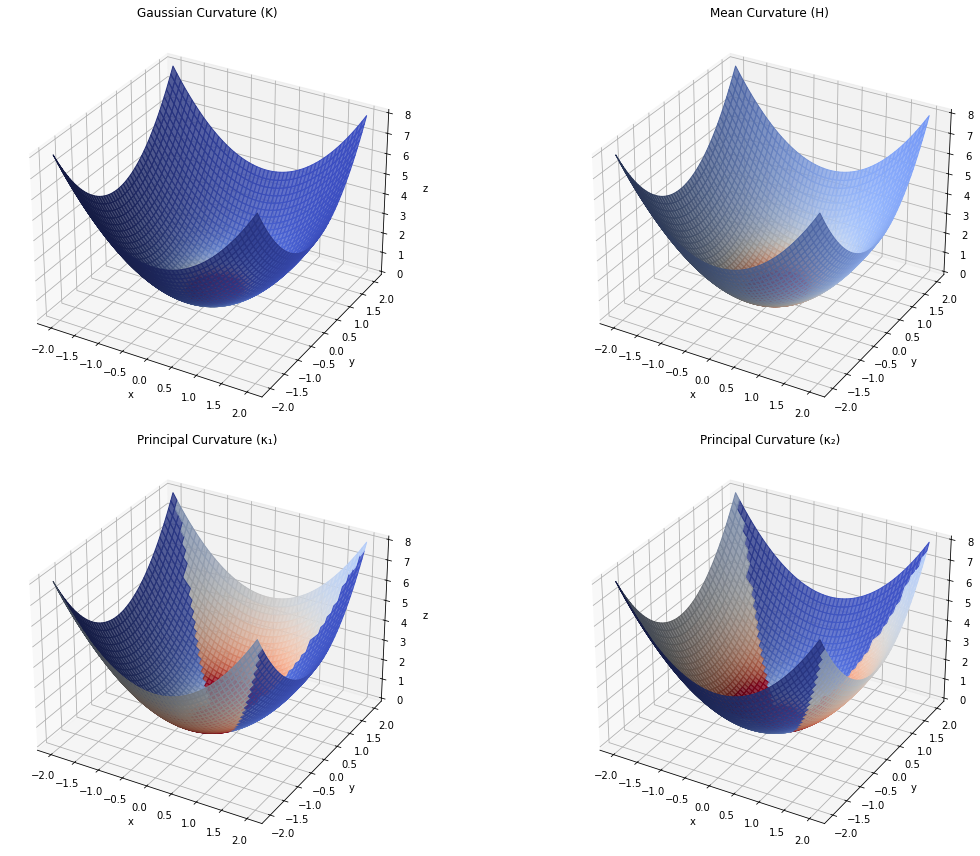

In [14]:
# Prob 3(g)

# Define the lifting function f(x, y)
def f(x, y):
    return x**2 + y**2

# Compute analytical derivatives
def compute_derivatives(x, y):
    fx = 2 * x
    fy = 2 * y
    fxx = 2
    fyy = 2
    fxy = 0  # Since f(x, y) = x^2 + y^2 is separable
    return fx, fy, fxx, fxy, fyy

# Compute the first fundamental form
def first_fundamental_form(fx, fy):
    E = 1 + fx**2
    F = fx * fy
    G = 1 + fy**2
    return np.array([[E, F], [F, G]])

# Compute the second fundamental form
def second_fundamental_form(fx, fy, fxx, fxy, fyy):
    denom = np.sqrt(1 + fx**2 + fy**2)
    L = fxx / denom
    M = fxy / denom
    N = fyy / denom
    return np.array([[L, M], [M, N]])

# Compute shape operator S = I⁻¹ II
def shape_operator(I, II):
    I_inv = np.linalg.inv(I)
    return np.dot(I_inv, II)

# Compute curvatures from the shape operator
def compute_curvatures(S):
    eigenvalues = np.linalg.eigvals(S)
    kappa1, kappa2 = eigenvalues
    K = kappa1 * kappa2  # Gaussian curvature
    H = (kappa1 + kappa2) / 2  # Mean curvature
    return kappa1, kappa2, K, H

# Create a grid of x, y points
x_vals = np.linspace(-2, 2, 50)
y_vals = np.linspace(-2, 2, 50)
X, Y = np.meshgrid(x_vals, y_vals)
Z = f(X, Y)

# Flatten for computation
x_flat, y_flat = X.flatten(), Y.flatten()
z_flat = Z.flatten()

# Initialize storage for curvature values
kappa1_values, kappa2_values, K_values, H_values = np.zeros_like(z_flat), np.zeros_like(z_flat), np.zeros_like(z_flat), np.zeros_like(z_flat)

# Compute curvatures at each vertex
for i in range(len(x_flat)):
    x_val, y_val = x_flat[i], y_flat[i]
    
    # Compute derivatives
    fx, fy, fxx, fxy, fyy = compute_derivatives(x_val, y_val)

    # Compute fundamental forms
    I = first_fundamental_form(fx, fy)
    II = second_fundamental_form(fx, fy, fxx, fxy, fyy)

    # Compute shape operator and curvatures
    S = shape_operator(I, II)
    kappa1, kappa2, K, H = compute_curvatures(S)

    # Store results
    kappa1_values[i] = kappa1
    kappa2_values[i] = kappa2
    K_values[i] = K
    H_values[i] = H

# Reshape into grid for plotting
kappa1_values = kappa1_values.reshape(X.shape)
kappa2_values = kappa2_values.reshape(X.shape)
K_values = K_values.reshape(X.shape)
H_values = H_values.reshape(X.shape)

# Plot the results
fig = plt.figure(figsize=(18, 12))

# Gaussian Curvature
ax1 = fig.add_subplot(221, projection='3d')
ax1.plot_surface(X, Y, Z, facecolors=plt.cm.coolwarm(K_values), rstride=1, cstride=1, alpha=0.8)
ax1.set_title('Gaussian Curvature (K)')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')

# Mean Curvature
ax2 = fig.add_subplot(222, projection='3d')
ax2.plot_surface(X, Y, Z, facecolors=plt.cm.coolwarm(H_values), rstride=1, cstride=1, alpha=0.8)
ax2.set_title('Mean Curvature (H)')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')

# Principal Curvature κ₁
ax3 = fig.add_subplot(223, projection='3d')
ax3.plot_surface(X, Y, Z, facecolors=plt.cm.coolwarm(kappa1_values), rstride=1, cstride=1, alpha=0.8)
ax3.set_title('Principal Curvature (κ₁)')
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_zlabel('z')

# Principal Curvature κ₂
ax4 = fig.add_subplot(224, projection='3d')
ax4.plot_surface(X, Y, Z, facecolors=plt.cm.coolwarm(kappa2_values), rstride=1, cstride=1, alpha=0.8)
ax4.set_title('Principal Curvature (κ₂)')
ax4.set_xlabel('x')
ax4.set_ylabel('y')
ax4.set_zlabel('z')

plt.tight_layout()
plt.show()


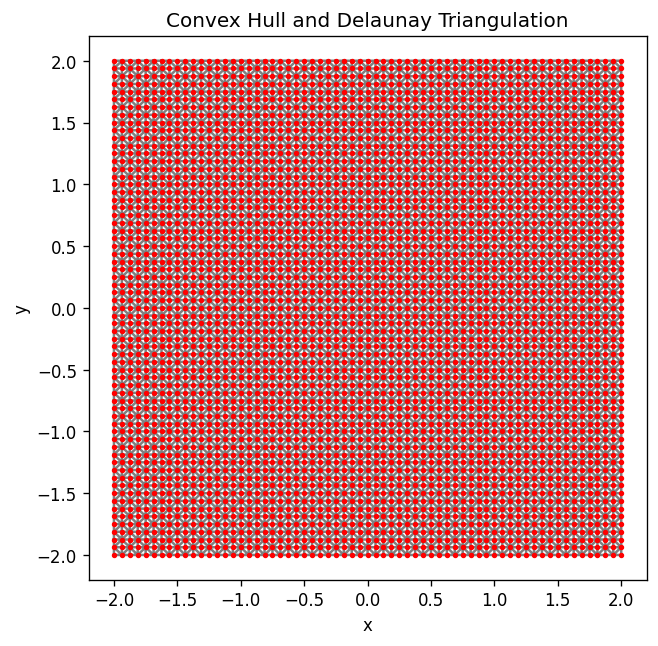

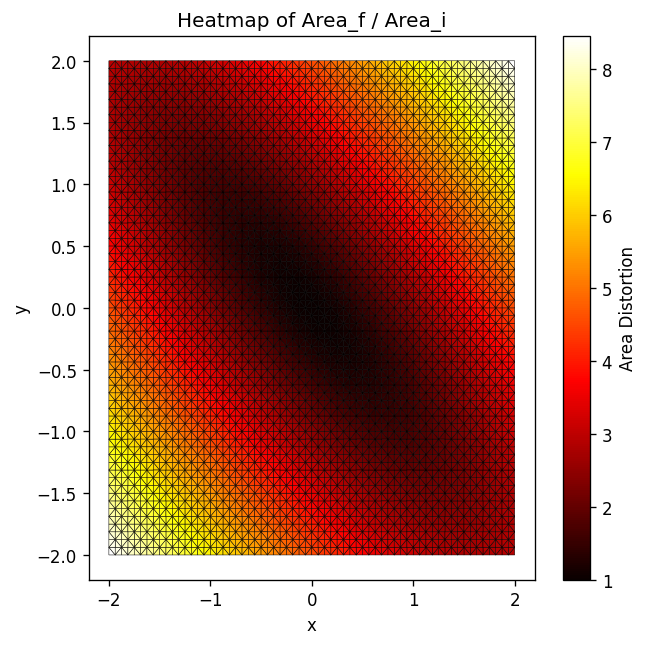

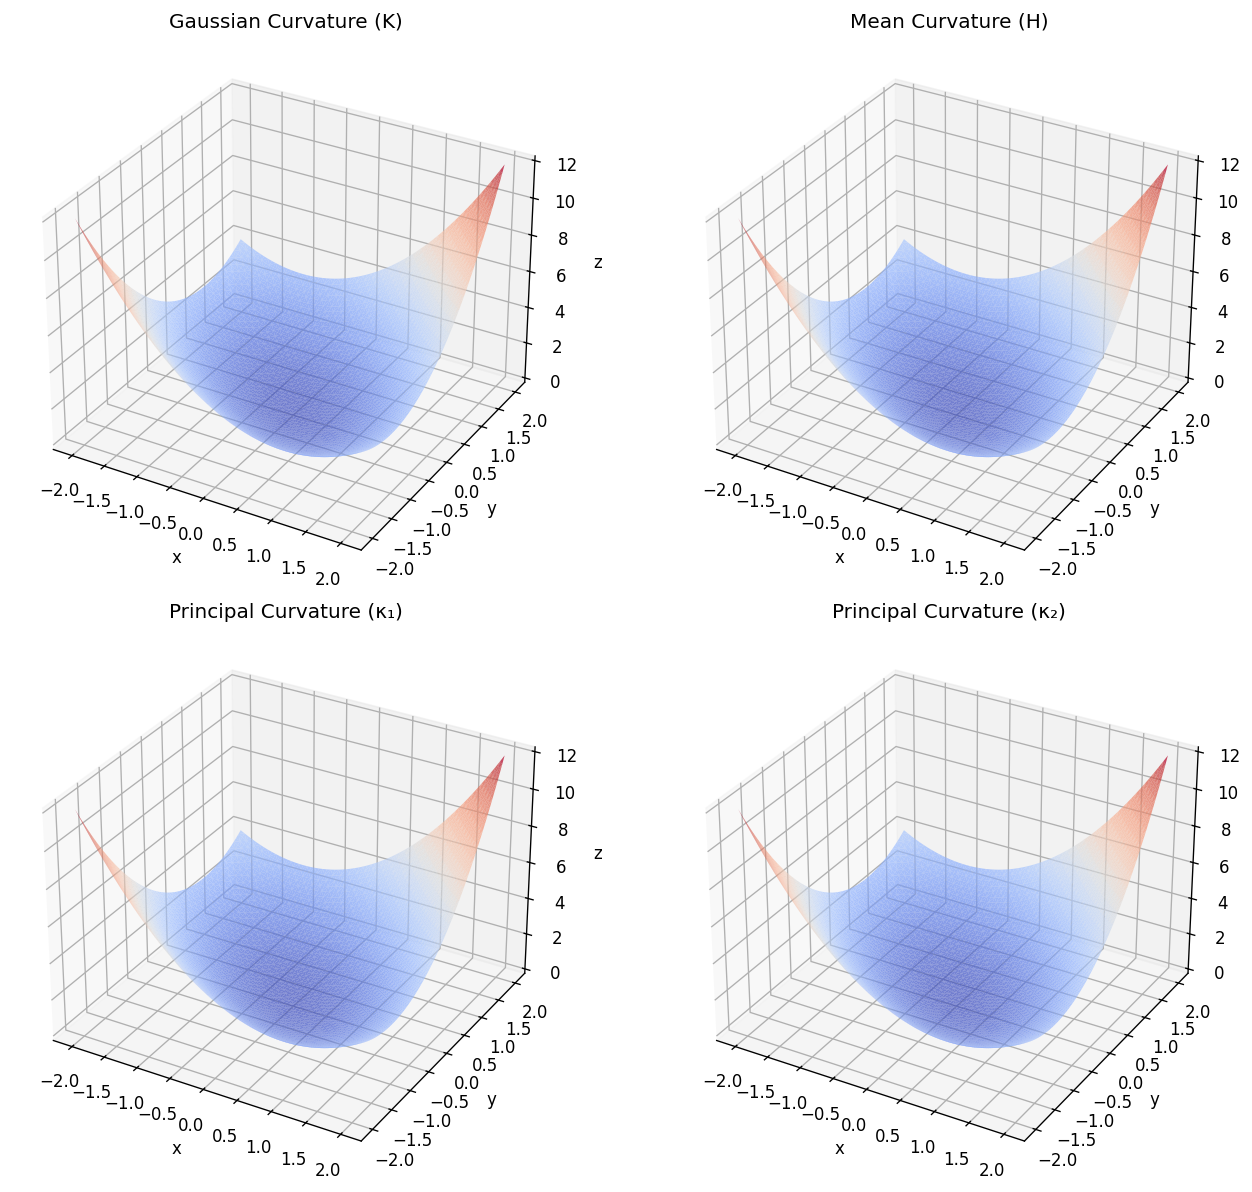

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull, Delaunay
from matplotlib.colors import Normalize

plt.rcParams['figure.dpi'] = 120

# Prob 3(h) - (b): Compute Convex Hull and Delaunay Triangulation

def lifting_map(x, y):
    return x**2 + x * y + y**2

def triangle_area(p1, p2, p3):
    return 0.5 * np.linalg.norm(np.cross(p2 - p1, p3 - p1))

# Mesh the surface
mesh = 65
x_vals = np.linspace(-2, 2, mesh)
y_vals = np.linspace(-2, 2, mesh)
X, Y = np.meshgrid(x_vals, y_vals)
points = np.column_stack((X.ravel(), Y.ravel()))
Z = lifting_map(points[:, 0], points[:, 1])

# Apply Delaunay triangulation
tri = Delaunay(points)
convex_hull = ConvexHull(points)

# Plot Convex Hull
plt.figure(figsize=(6, 6))
plt.triplot(points[:, 0], points[:, 1], tri.simplices, 'k-', alpha=0.5)
plt.scatter(points[:, 0], points[:, 1], s=5, color='red')
plt.title("Convex Hull and Delaunay Triangulation")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# Prob 3(h) - (c): Compute Area Changes
area_change = []
for simplex in tri.simplices:
    p1, p2, p3 = points[simplex]
    p1_lifted = np.array([p1[0], p1[1], lifting_map(p1[0], p1[1])])
    p2_lifted = np.array([p2[0], p2[1], lifting_map(p2[0], p2[1])])
    p3_lifted = np.array([p3[0], p3[1], lifting_map(p3[0], p3[1])])
    area_original = triangle_area(p1, p2, p3)
    area_lifted = triangle_area(p1_lifted, p2_lifted, p3_lifted)
    area_change.append(area_lifted / area_original)

# Plot Area Change
plt.figure(figsize=(6, 6))
plt.tripcolor(points[:, 0], points[:, 1], tri.simplices, facecolors=area_change, cmap='hot', edgecolors='k', linewidth=0.3)
plt.colorbar(label="Area Distortion")
plt.title("Heatmap of Area_f / Area_i")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# Prob 3(h) - (d): Compute Induced Metric (First Fundamental Form)
def induced_metric_analytic(x, y):
    g_11 = 1 + (2 * x + y) ** 2
    g_12 = (2 * x + y) * (2 * y + x)
    g_22 = 1 + (2 * y + x) ** 2
    return np.array([[g_11, g_12], [g_12, g_22]])

# Prob 3(h) - (e): Compute Normal Vectors
def compute_normal(tri_coord):
    v1, v2, v3 = tri_coord
    edge1 = v2 - v1
    edge2 = v3 - v1
    normal = np.cross(edge1, edge2)
    return normal / np.linalg.norm(normal)

normals = np.array([compute_normal(np.array([
    [points[i][0], points[i][1], Z[i]] for i in simplex
])) for simplex in tri.simplices])

centers = np.array([
    np.mean([[points[i][0], points[i][1], Z[i]] for i in simplex], axis=0)
    for simplex in tri.simplices
])

# Prob 3(h) - (f): Compute Second Fundamental Form
x = points[:, 0]
y = points[:, 1]

A = (2 * np.ones_like(x))  # ∂²f/∂x²
B = (1 * np.ones_like(x))  # ∂²f/∂x∂y
C = B  # Symmetric
D = (2 * np.ones_like(y))  # ∂²f/∂y²

matrix = np.stack([A, B, C, D], axis=-1).reshape(-1, 2, 2)

# Prob 3(h) - (g): Compute Shape Operator and Curvatures
def shape_operator(I, II):
    I_inv = np.linalg.inv(I)
    return np.dot(I_inv, II)

def compute_curvatures(S):
    eigenvalues = np.linalg.eigvals(S)
    kappa1, kappa2 = eigenvalues
    K = kappa1 * kappa2  # Gaussian curvature
    H = (kappa1 + kappa2) / 2  # Mean curvature
    return kappa1, kappa2, K, H

kappa1_values, kappa2_values, K_values, H_values = np.zeros_like(x), np.zeros_like(x), np.zeros_like(x), np.zeros_like(x)

for i in range(len(x)):
    I = induced_metric_analytic(x[i], y[i])
    II = np.array([[A[i], B[i]], [C[i], D[i]]])
    S = shape_operator(I, II)
    kappa1, kappa2, K, H = compute_curvatures(S)
    kappa1_values[i] = kappa1
    kappa2_values[i] = kappa2
    K_values[i] = K
    H_values[i] = H

# Plot Curvatures
fig, axes = plt.subplots(2, 2, figsize=(12, 10), subplot_kw={'projection': '3d'})

for ax, data, title in zip(axes.flatten(), [K_values, H_values, kappa1_values, kappa2_values],
                           ['Gaussian Curvature (K)', 'Mean Curvature (H)', 'Principal Curvature (κ₁)', 'Principal Curvature (κ₂)']):
    ax.plot_trisurf(x, y, Z, triangles=tri.simplices, cmap='coolwarm', alpha=0.7)
    ax.set_title(title)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")

plt.tight_layout()
plt.show()
